In [ ]:
!pip install lightgbm;
!pip install pymoo;
!pip install -U pyrecorder;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 
     |████████████████████████████████| 239 kB 38.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyrecorder: filename=pyrecorder-0.2.1-py3-none-any.whl size=12668 sha256=c8e6ac9f04377006a6efcc5ae28121706def4095d89af6d9fd5588f734443ad5
  Stored in directory: /root/.cache/pip/wheels/ab/f6/3f/06285a1cfc14dd359589a2df9ebe181ad2999cc2c041f4b904
Successfully built pyrecorder


In [ ]:
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
import numpy as np
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold
from google.colab import drive
import pickle
from pymoo.algorithms.soo.nonconvex.pso import PSO, PSOAnimation
from pymoo.factory import Rastrigin
from pymoo.optimize import minimize
import matplotlib.pyplot as plt
from pymoo.factory import get_termination
from pymoo.util.display import Display
from pymoo.core.callback import Callback

In [ ]:
import lightgbm as lgb

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('/content/gdrive/MyDrive/datasets/credit.pkl', 'rb') as f:
    x_credit_train, x_credit_test, y_credit_train, y_credit_test = pickle.load(f)

In [ ]:

x_credit = np.concatenate((x_credit_train, x_credit_test), axis = 0)
y_credit = np.concatenate((y_credit_train, y_credit_test), axis = 0)


Definindo as restrições 

In [ ]:
OBJECTIVE = ['Accuracy']
DIMENSIONS = 9 #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, subsample, reg_alpha, reg_lambda
ITERATIONS = 1000
POPULATION = 15
num_leaves_min = 10
num_leaves_max = 200
min_child_samples_min = 10
min_child_samples_max = 50
n_estimators_min = 20
n_estimators_max = 1000

learning_rate_min = 0.001
learning_rate_max = 0.5
subsample_for_bin_min = 50000
subsample_for_bin_max = 500000
min_split_gain_min = 0.01
min_split_gain_max = 0.5
min_child_weight_min = 0.001
min_child_weight_max = 0.15
subsample_min = 1.0
subsample_max = 2.0
reg_alpha_min =0.01
reg_alpha_max = 100.0 
reg_lambda_min = 0.01
reg_lambda_max = 100.0

BOUNDS = []
SEED = 1
INDIVIDUALS = []

Definindo o problema

In [ ]:
import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var= DIMENSIONS,
                         n_obj=1,
                         n_constr=9,
                         xl=np.array([num_leaves_min, min_child_samples_min, n_estimators_min, learning_rate_min, subsample_for_bin_min,
                                      min_split_gain_min, min_child_weight_min, reg_alpha_min, reg_lambda_min]),
                         xu=np.array([num_leaves_max, min_child_samples_max, n_estimators_max, learning_rate_max, subsample_for_bin_max,
                                      min_split_gain_max, min_child_weight_max, reg_alpha_max, reg_lambda_max])
                        )

    def _evaluate(self, x, out, *args, **kwargs):
        #num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
        
        model_lgb = lgb.LGBMClassifier(num_leaves        = int(np.floor(x[0])), 
                                       min_child_samples = int(np.floor(x[1])), 
                                       n_estimators      = int(np.floor(x[2])),
                                       learning_rate     = x[3] ,
                                       subsample_for_bin = int(np.floor(x[4])),
                                       min_split_gain    = x[5],
                                       min_child_weight  = x[6],
                                       reg_alpha         = x[7],
                                       reg_lambda        = x[8],
                                       max_depth=- 1,
                                       n_jobs = -1
                                       )
        
        kfold = KFold(n_splits = 3, shuffle = True)
        
        scores = cross_val_score(model_lgb, x_credit, y_credit, cv = kfold, n_jobs=-1)  
        
        result = scores.mean()
        out['F'] = -1 * result
        out['G'] = -1 * result
        #[((x[0]) * (x[1]) * (x[2]) * (x[3]) * (x[4]) * (x[5]) * (x[6]) * (x[7]) * (x[8]) * (x[9]) )/ 10]


problem = MyProblem()

In [ ]:
class MyDisplay(Display):
    def _do(self, problem, evaluator, algorithm):
        super()._do(problem, evaluator, algorithm)
        #self.output.append("metric_a", np.mean(algorithm.pop.get("X")))
        self.output.append("Accuracy", -np.min(algorithm.pop.get("F")))

class MyCallback(Callback):

    def __init__(self) -> None:
        super().__init__()
        #self.data["best"] = []
        global pbar 
        pbar = tqdm(total=ITERATIONS)
    def notify(self, algorithm):
        pbar.update(1)
        if pbar.n == ITERATIONS: pbar.close()

## Particle Swarm Optimization (PSO)

In [ ]:
ITERATIONS = 32
POPULATION = 32

In [ ]:
algorithm = PSO(max_velocity_rate=0.25,
                pop_size=POPULATION)
term = get_termination("n_gen", ITERATIONS)

res = minimize(problem,
               algorithm,
               #seed=SEED,
               save_history=True,
               verbose=True,
               display=MyDisplay(),
               callback=MyCallback(),
               termination = term)

print(f"Accuracy Score = {(-res.F)}")
#num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
print(f"HiperParameters = \n num_leaves ->  {res.X[0]} \n min_child_samples ->  {res.X[1]} \n n_estimators ->  {res.X[2]} \n learning_rate ->  {res.X[3]} \n subsample_for_bin ->  {res.X[4]}")
print(f' min_split_gain ->  {res.X[5]} \n min_child_weight ->  {res.X[6]} \n reg_alpha ->  {res.X[7]} \n reg_lambda ->  {res.X[8]}')

  0%|          | 0/32 [00:00<?, ?it/s]

n_gen |  n_eval |   Accuracy  
    1 |      32 |  0.841379943
    2 |      64 |  0.841379952
    3 |      96 |  0.842300818
    4 |     128 |  0.842484805
    5 |     160 |  0.842484805
    6 |     192 |  0.843129539
    7 |     224 |  0.843129539
    8 |     256 |  0.843129539
    9 |     288 |  0.843129539
   10 |     320 |  0.843129539
   11 |     352 |  0.843129539
   12 |     384 |  0.843129539
   13 |     416 |  0.843129539
   14 |     448 |  0.843589843
   15 |     480 |  0.843589843
   16 |     512 |  0.843589843
   17 |     544 |  0.843589843
   18 |     576 |  0.843589843
   19 |     608 |  0.843589843
   20 |     640 |  0.843589843
   21 |     672 |  0.843589843
   22 |     704 |  0.843589843
   23 |     736 |  0.843589843
   24 |     768 |  0.843589843
   25 |     800 |  0.843589843
   26 |     832 |  0.843589843
   27 |     864 |  0.843589843
   28 |     896 |  0.843589843
   29 |     928 |  0.843589843
   30 |     960 |  0.843589843
   31 |     992 |  0.843589843
   32 | 

In [ ]:
res.X

array([1.28761489e+02, 2.78377378e+01, 1.90073958e+02, 3.18309748e-01,
       2.59842791e+05, 1.92315395e-01, 8.00627465e-02, 4.03639490e-01,
       9.19507309e+01])

In [ ]:
final_model = lgb.LGBMClassifier(num_leaves       = int(np.floor(res.X[0])), 
                                min_child_samples = int(np.floor(res.X[1])), 
                                n_estimators      = int(np.floor(res.X[2])),
                                learning_rate     = res.X[3] ,
                                subsample_for_bin = int(np.floor(res.X[4])),
                                min_split_gain    = res.X[5],
                                min_child_weight  = res.X[6],
                                reg_alpha         = res.X[7],
                                reg_lambda        = res.X[8],
                                max_depth=- 1
                                )
kfold = KFold(n_splits = 3, shuffle = True)

scores = cross_val_score(final_model, x_credit, y_credit, cv = kfold, n_jobs=-1)  

result = scores.mean()
print(result)

0.8410730431516192


In [ ]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [ ]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [ ]:
scorelist_PSO = scorelist

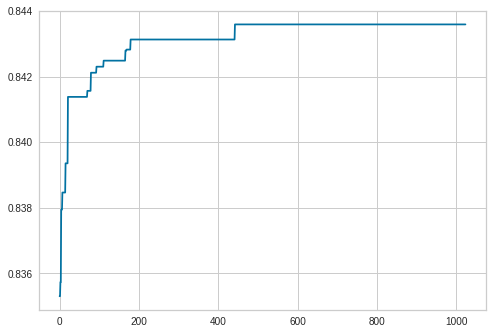

In [ ]:
plt.plot(scorelist);

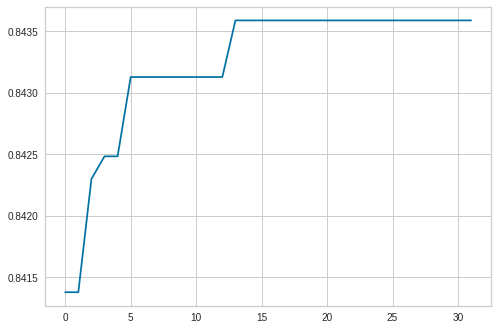

In [ ]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_PSO = tracking
plt.plot(tracking)

## Algoritmo Genético (GA)

In [ ]:
ITERATIONS = 32
POPULATION = 32

In [ ]:
from pymoo.algorithms.soo.nonconvex.ga import GA

algorithm = GA(pop_size=POPULATION)

term = get_termination("n_gen", ITERATIONS)

res = minimize(problem,
               algorithm,
               #seed=SEED,
               save_history=True,
               verbose=True,
               display=MyDisplay(),
               callback=MyCallback(),
               termination = term)

print(f"Accuracy Score = {(-res.F)}")
#num_leaves, min_child_samples, n_estimators, learning_rate, subsample_for_bin, min_split_gain, min_child_weight, reg_alpha, reg_lambda
print(f"HiperParameters = \n num_leaves ->  {res.X[0]} \n min_child_samples ->  {res.X[1]} \n n_estimators ->  {res.X[2]} \n learning_rate ->  {res.X[3]} \n subsample_for_bin ->  {res.X[4]}")
print(f' min_split_gain ->  {res.X[5]} \n min_child_weight ->  {res.X[6]} \n reg_alpha ->  {res.X[7]} \n reg_lambda ->  {res.X[8]}')

  0%|          | 0/32 [00:00<?, ?it/s]

n_gen |  n_eval |   Accuracy  
    1 |      32 |  0.842177843
    2 |      64 |  0.842177843
    3 |      96 |  0.842177843
    4 |     128 |  0.842177843
    5 |     160 |  0.842454264
    6 |     192 |  0.842975853
    7 |     224 |  0.843589764
    8 |     256 |  0.843589764
    9 |     288 |  0.843589764
   10 |     320 |  0.843589764
   11 |     352 |  0.843589764
   12 |     384 |  0.843589764
   13 |     416 |  0.843589764
   14 |     448 |  0.843589764
   15 |     480 |  0.843589764
   16 |     512 |  0.843835398
   17 |     544 |  0.843835398
   18 |     576 |  0.843835398
   19 |     608 |  0.843835398
   20 |     640 |  0.843835398
   21 |     672 |  0.843835398
   22 |     704 |  0.843835398
   23 |     736 |  0.843835398
   24 |     768 |  0.843835398
   25 |     800 |  0.843835398
   26 |     832 |  0.843835398
   27 |     864 |  0.843835398
   28 |     896 |  0.843835398
   29 |     928 |  0.843835398
   30 |     960 |  0.843835398
   31 |     992 |  0.843835398
   32 | 

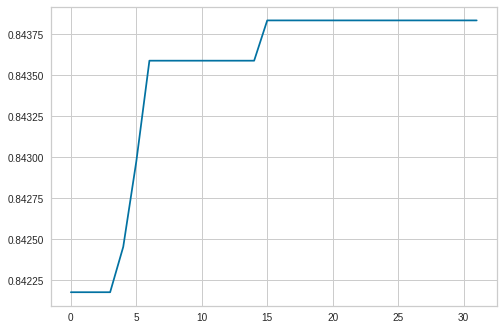

In [ ]:
tracking = [-np.min(individual.pop.get('F')) for individual in res.history ]
tracking_GA = tracking
plt.plot(tracking)

In [ ]:
trlist = np.array([])
for i in range(len(res.history)):
  trlist = np.append(trlist, -res.history[i].pop.get('F').reshape(-1)) 

In [ ]:
scorelist = []

for i in range(len(trlist)):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

In [ ]:
scorelist_GA = scorelist

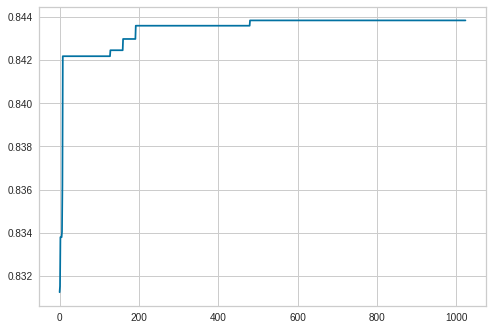

In [ ]:
plt.plot(scorelist);

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
n_possibilities = 2

#num_leaves_grid = [i for i in range(num_leaves_min,num_leaves_max, int((num_leaves_max)/13))]
num_leaves_grid = [i for i in map(lambda x: int(x), np.linspace(num_leaves_min, num_leaves_max, n_possibilities))]
num_leaves_grid = num_leaves_grid + [100, 50, 75, 125, 11,150]
print('Num_Leaves_Grid: ')
print(num_leaves_grid, len(num_leaves_grid))
print('\n')


min_child_samples_grid = [i for i in map(lambda x: int(x), np.linspace(min_child_samples_min, min_child_samples_max, n_possibilities))]
print('min_child_samples_grid:')
print(min_child_samples_grid, len(min_child_samples_grid))
print('\n')

n_estimators_grid = [i for i in map(lambda x: int(x), np.linspace(n_estimators_min, n_estimators_max, n_possibilities))]
print('n_estimators_grid:')
print(n_estimators_grid, len(n_estimators_grid))
print('\n')

learning_rate_grid = np.linspace(learning_rate_min, learning_rate_max, n_possibilities)
print('learning_rate_grid:')
print(learning_rate_grid, len(learning_rate_grid))
print('\n')

subsample_for_bin_grid = [i for i in map(lambda x: int(x), np.linspace(subsample_for_bin_min, subsample_for_bin_max, n_possibilities))]
print('subsample_for_bin_grid:')
print(subsample_for_bin_grid, len(subsample_for_bin_grid))
print('\n')

min_split_gain_grid = np.linspace(min_split_gain_min, min_split_gain_max, n_possibilities)
print('min_split_gain_grid:')
print(min_split_gain_grid, len(min_split_gain_grid))
print('\n')

min_child_weight_grid = np.linspace(min_child_weight_min, min_child_weight_max, n_possibilities)
print('min_child_weight_grid:')
print(min_child_weight_grid, len(min_child_weight_grid))
print('\n')

reg_alpha_grid = np.linspace(reg_alpha_min, reg_alpha_max, n_possibilities)
print('reg_alpha_grid:')
print(reg_alpha_grid, len(reg_alpha_grid))
print('\n')


Num_Leaves_Grid: 
[10, 200, 100, 50, 75, 125, 11, 150] 8


min_child_samples_grid:
[10, 50] 2


n_estimators_grid:
[20, 1000] 2


learning_rate_grid:
[0.001 0.5  ] 2


subsample_for_bin_grid:
[50000, 500000] 2


min_split_gain_grid:
[0.01 0.5 ] 2


min_child_weight_grid:
[0.001 0.15 ] 2


reg_alpha_grid:
[1.e-02 1.e+02] 2




In [ ]:
parametros = {'num_leaves': num_leaves_grid, #int
              'min_child_samples': min_child_samples_grid,#int
              'n_estimators': n_estimators_grid, #int
              'learning_rate': learning_rate_grid,
              'subsample_for_bin': subsample_for_bin_grid, # int
              'min_split_gain': min_split_gain_grid,
              'min_child_weight': min_child_weight_grid,
              'reg_alpha': reg_alpha_grid,
              'max_depth': [-1],
              'n_jobs': [-1]}

In [ ]:
kfold = KFold(n_splits = 3, shuffle = True)
grid_search = GridSearchCV(estimator = lgb.LGBMClassifier(), param_grid = parametros, cv = kfold, n_jobs= -1, verbose = 3)
grid_search.fit(x_credit, y_credit)
melhores_parametros = grid_search.best_params_
melhor_resultado = grid_search.best_score_
print(melhores_parametros)
print(melhor_resultado)

Fitting 3 folds for each of 1024 candidates, totalling 3072 fits
{'learning_rate': 0.5, 'max_depth': -1, 'min_child_samples': 50, 'min_child_weight': 0.001, 'min_split_gain': 0.5, 'n_estimators': 20, 'n_jobs': -1, 'num_leaves': 150, 'reg_alpha': 0.01, 'subsample_for_bin': 50000}
0.840336332728164


In [ ]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_min_child_samples', 'param_min_child_weight', 'param_min_split_gain', 'param_n_estimators', 'param_n_jobs', 'param_num_leaves', 'param_reg_alpha', 'param_subsample_for_bin', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [ ]:
trlist = grid_search.cv_results_['mean_test_score']

In [ ]:
scorelist = []

for i in range(len(trlist)):
#for i in range(1):
  if i == 0:
    scorelist.append(trlist[i])
  elif trlist[i] > scorelist[i-1]:
    scorelist.append(trlist[i])
  else:
    scorelist.append(scorelist[i-1])

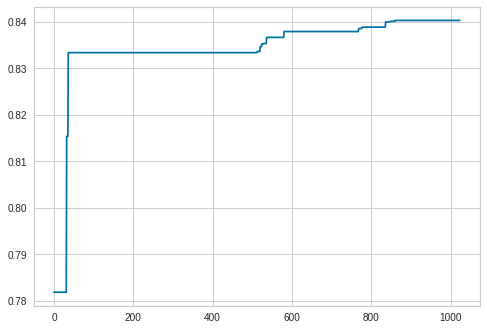

In [ ]:
tracking_GS = scorelist
plt.plot(scorelist); 

## Optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.8 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 209 kB 55.3 MB/s 
     |████████████████████████████████| 78 kB 6.8 MB/s 
     |████████████████████████████████| 146 kB 51.3 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 5.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=1b1773260cfc01675e61dd8aa779df5e2f3cf2c856fee54f69f10ec898a9263b
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
import sklearn
from sklearn import datasets
def objective(trial):
  
      num_leaves = trial.suggest_int('num_leaves', num_leaves_min, num_leaves_max) #int
      min_child_samples = trial.suggest_int('min_child_samples', min_child_samples_min, min_child_samples_max) #int
      n_estimators      = trial.suggest_int('n_estimators', n_estimators_min, n_estimators_max)#int
      learning_rate     = trial.suggest_float('learning_rate', learning_rate_min, learning_rate_max)
      subsample_for_bin = trial.suggest_int('subsample_for_bin', subsample_for_bin_min, subsample_for_bin_max) #int
      min_split_gain    = trial.suggest_float('min_split_gain', min_split_gain_min, min_split_gain_max)
      min_child_weight  = trial.suggest_float('min_child_weight', min_child_weight_min, min_child_weight_max)
      reg_alpha         = trial.suggest_float('reg_alpha', reg_alpha_min, reg_alpha_max)
      reg_lambda        = trial.suggest_float('reg_lambda', reg_lambda_min, reg_lambda_max)

      final_model = lgb.LGBMClassifier(num_leaves       = num_leaves, 
                                      min_child_samples = min_child_samples, 
                                      n_estimators      = n_estimators,
                                      learning_rate     = learning_rate,
                                      subsample_for_bin = subsample_for_bin,
                                      min_split_gain    = min_split_gain,
                                      min_child_weight  = min_child_weight,
                                      reg_alpha         = reg_alpha,
                                      reg_lambda        = reg_lambda,
                                      max_depth= -1,
                                      n_jobs = -1
                                      )
      
      kfold = KFold(n_splits = 3, shuffle = True)

      return sklearn.model_selection.cross_val_score(final_model, x_credit, y_credit, n_jobs=-1, cv=kfold).mean()

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1024)

[I 2022-07-13 03:18:45,037] A new study created in memory with name: no-name-0e8e357b-303f-4aa6-a37d-93bd3183e2ed
[I 2022-07-13 03:18:47,095] Trial 0 finished with value: 0.8393236476850818 and parameters: {'num_leaves': 85, 'min_child_samples': 14, 'n_estimators': 415, 'learning_rate': 0.09367010651819173, 'subsample_for_bin': 158323, 'min_split_gain': 0.14320333091900145, 'min_child_weight': 0.1382454767412765, 'reg_alpha': 5.68725657950599, 'reg_lambda': 46.56148719306046}. Best is trial 0 with value: 0.8393236476850818.
[I 2022-07-13 03:18:47,596] Trial 1 finished with value: 0.8332158574597054 and parameters: {'num_leaves': 173, 'min_child_samples': 44, 'n_estimators': 143, 'learning_rate': 0.15987951550997156, 'subsample_for_bin': 287033, 'min_split_gain': 0.3787590016993449, 'min_child_weight': 0.05840675155715885, 'reg_alpha': 52.84676925308599, 'reg_lambda': 42.14203703977501}. Best is trial 0 with value: 0.8393236476850818.
[I 2022-07-13 03:18:49,431] Trial 2 finished with va

In [ ]:
trial = study.best_trial
print('Accuracy: {}'.format(trial.value))

Accuracy: 0.8434361906402627


In [ ]:
print("Best hyperparameters: {}".format(trial.params))

Best hyperparameters: {'num_leaves': 130, 'min_child_samples': 34, 'n_estimators': 888, 'learning_rate': 0.14736552536781647, 'subsample_for_bin': 175518, 'min_split_gain': 0.10595867959293914, 'min_child_weight': 0.08144333549688511, 'reg_alpha': 1.8602656970399696, 'reg_lambda': 10.03775060186732}


In [ ]:
tracking = []
for i in range(len(study.trials)):
  if i == 0: 
    tracking.append(study.trials[i].value)
  elif tracking[i-1] > study.trials[i].value:
    tracking.append(tracking[i-1])
  else:
    tracking.append(study.trials[i].value)
#tracking_sorted = sorted(tracking)

In [ ]:
tracking_Optuna = tracking

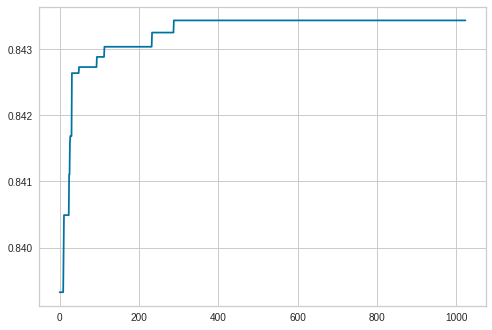

In [ ]:
plt.plot(tracking);
#plt.plot(tracking_sorted) 

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

# Análise Comparativa

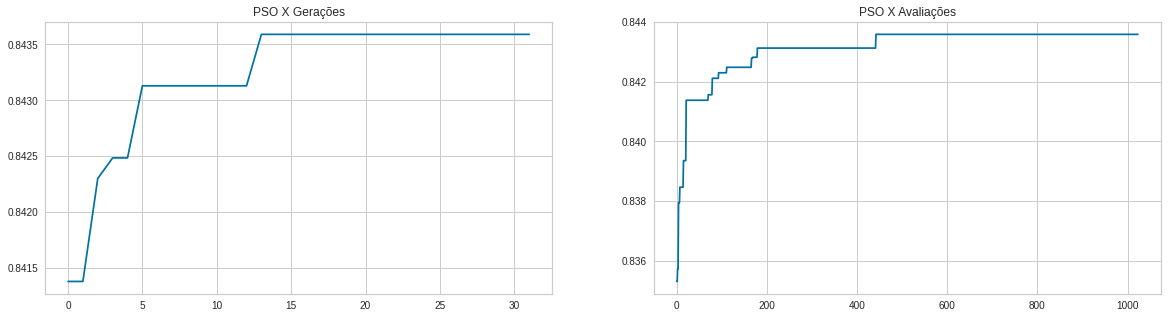

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('PSO X Gerações')
ax2.set_title('PSO X Avaliações')

ax1.plot(tracking_PSO)
ax2.plot(scorelist_PSO)
plt.show()

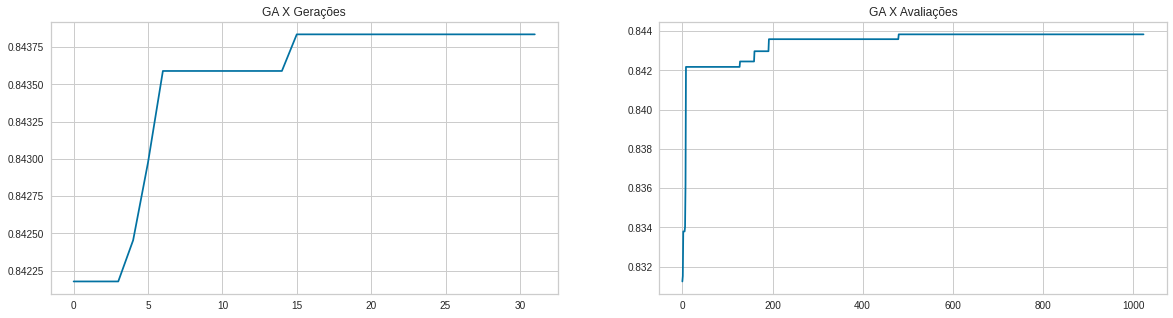

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))

ax1.set_title('GA X Gerações')
ax2.set_title('GA X Avaliações')

ax1.plot(tracking_GA)
ax2.plot(scorelist_GA)
plt.show()

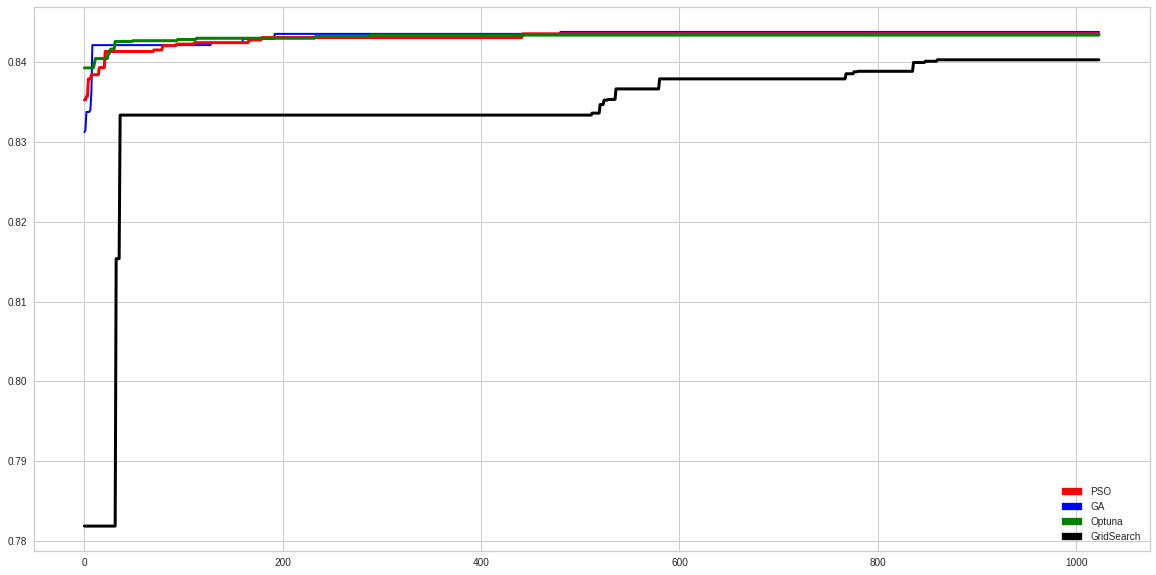

In [ ]:
from IPython.core.pylabtools import figsize
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches

plt.figure(figsize=(20, 10))
red_patch = mpatches.Patch(color='red', label='PSO')
blue_patch = mpatches.Patch(color='blue', label='GA')
green_patch = mpatches.Patch(color='green', label='Optuna')
black_patch = mpatches.Patch(color='black', label='GridSearch')

plt.legend(handles=[red_patch, blue_patch, green_patch, black_patch])
plt.plot(scorelist_GA, color = 'blue', linewidth=2, linestyle='-', )
plt.plot(scorelist_PSO, color = 'red', linewidth=3, linestyle='-')
plt.plot(tracking_Optuna, color = 'green', linewidth=3, linestyle='-')
plt.plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
plt.show()

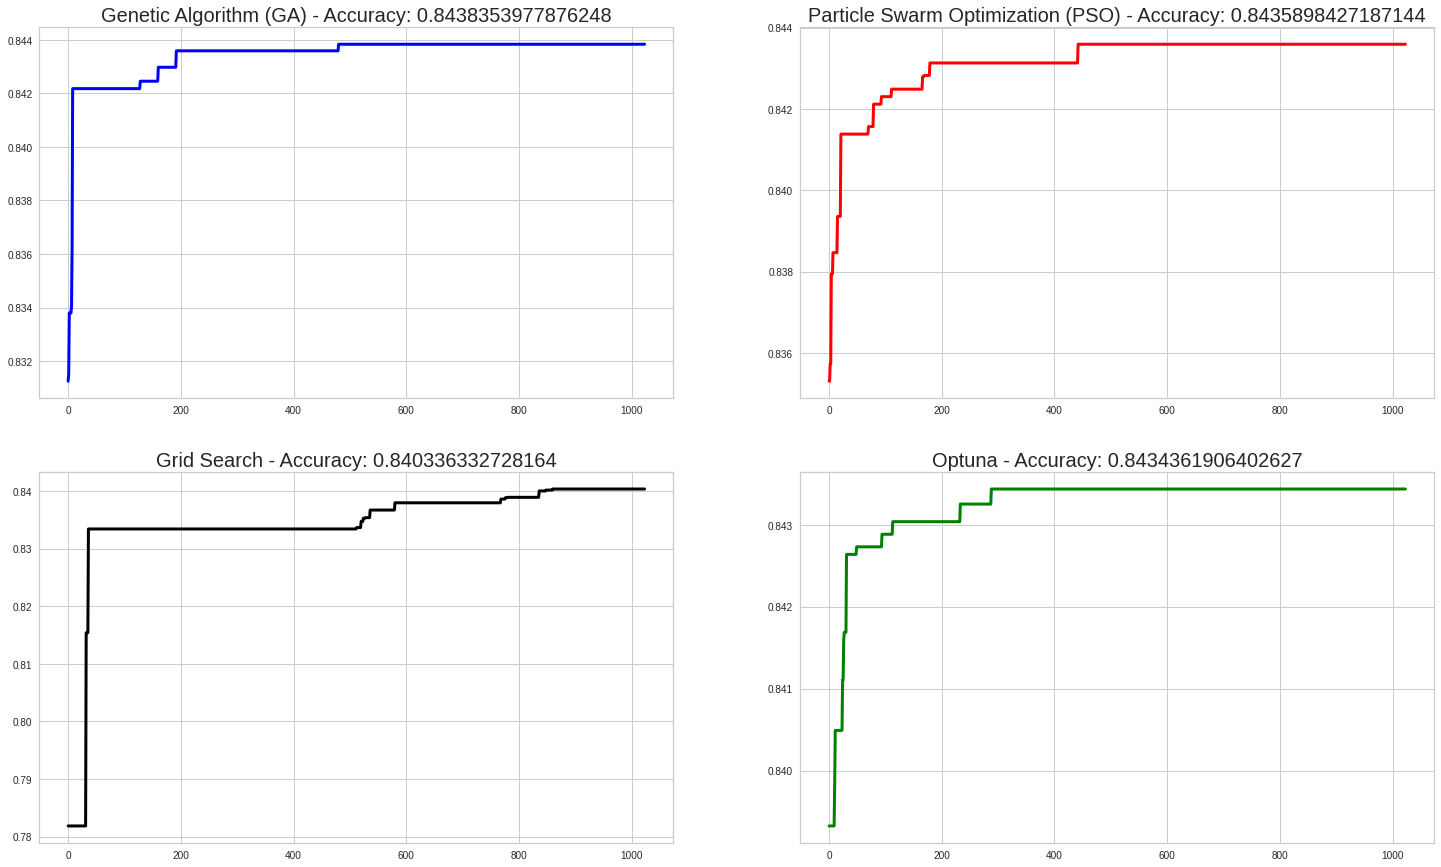

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(25,15))

ax[0, 0].set_title(f'Genetic Algorithm (GA) - Accuracy: {max(scorelist_GA)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[0, 1].set_title(f'Particle Swarm Optimization (PSO) - Accuracy: {max(scorelist_PSO)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[1, 0].set_title(f'Grid Search - Accuracy: {max(tracking_GS)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})
ax[1, 1].set_title(f'Optuna - Accuracy: {max(tracking_Optuna)}', fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax[0,0].plot(scorelist_GA, color = 'blue', linewidth=3, linestyle='-', )
ax[0,1].plot(scorelist_PSO, color = 'red', linewidth=3, linestyle='-')

ax[1,0].plot(tracking_GS, color = 'black', linewidth=3, linestyle='-')
ax[1,1].plot(tracking_Optuna, color = 'green', linewidth=3, linestyle='-')
